<a href="https://colab.research.google.com/github/anurag19997/Sentdex-Practice/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar 25 04:41:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset, info = tfds.load(name='beans', split=['train', 'test', 'validation'], as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteU1S5F4/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteU1S5F4/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteU1S5F4/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


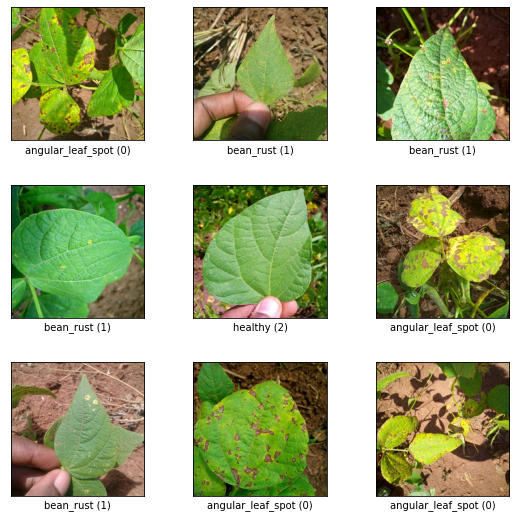

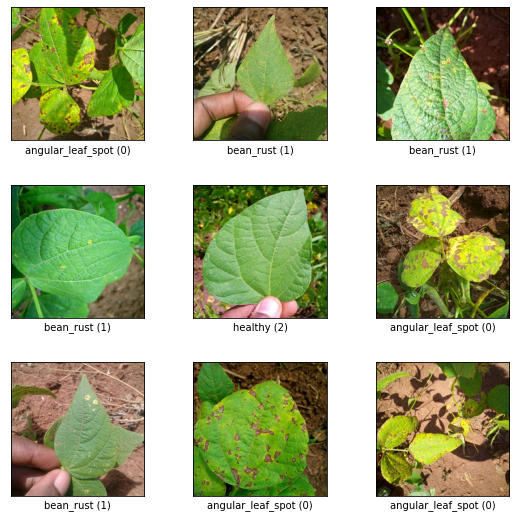

In [7]:
train, info = tfds.load(name='beans', with_info=True, split='test')
tfds.show_examples(info, train)

In [8]:
def scale(image, label):
  image = tf.cast(image, np.float32)
  image = image/255.
  image = tf.image.resize(image, [224,224])
  label = tf.one_hot(label, 3)
  
  return image, label 

In [10]:
def get_dataset(batch_size=64):
  train = dataset[0].map(scale).shuffle(1000).batch(batch_size)
  test = dataset[1].map(scale).batch(batch_size)
  val = dataset[2].map(scale).batch(batch_size)

  return train, test, val

In [12]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [17]:
len(dataset[0])

1034

In [18]:
feature_vector_extract_handle = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_vector_extract_layer = hub.KerasLayer(feature_vector_extract_handle, input_shape=(224,224,3), trainable=False)

In [22]:
def create_model():
  return tf.keras.models.Sequential([feature_vector_extract_layer,
                                     tf.keras.layers.Dropout(0.4),
                                     tf.keras.layers.Dense(3, activation='softmax')])

In [24]:
model = create_model()
print(model.summary())
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [25]:
history = model.fit(train_dataset, epochs=6, validation_data=val_dataset)

Epoch 1/6
17/17 [==============================] - 38s 170ms/step - loss: 1.2666 - acc: 0.4286 - val_loss: 0.6366 - val_acc: 0.7068
Epoch 2/6
17/17 [==============================] - 3s 99ms/step - loss: 0.7238 - acc: 0.6822 - val_loss: 0.4754 - val_acc: 0.8421
Epoch 3/6
17/17 [==============================] - 3s 99ms/step - loss: 0.5744 - acc: 0.7434 - val_loss: 0.4087 - val_acc: 0.8496
Epoch 4/6
17/17 [==============================] - 3s 98ms/step - loss: 0.4941 - acc: 0.7882 - val_loss: 0.3888 - val_acc: 0.8571
Epoch 5/6
17/17 [==============================] - 3s 100ms/step - loss: 0.4430 - acc: 0.8115 - val_loss: 0.3510 - val_acc: 0.8797
Epoch 6/6
17/17 [==============================] - 3s 100ms/step - loss: 0.3895 - acc: 0.8479 - val_loss: 0.3309 - val_acc: 0.8797


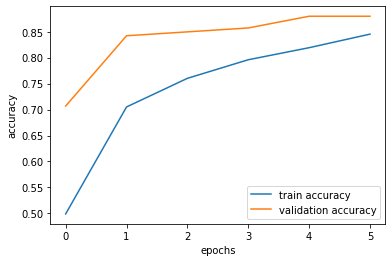

In [31]:
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')

In [32]:
result = model.evaluate(test_dataset)

2/2 [==============================] - 1s 186ms/step - loss: 0.3246 - acc: 0.8750


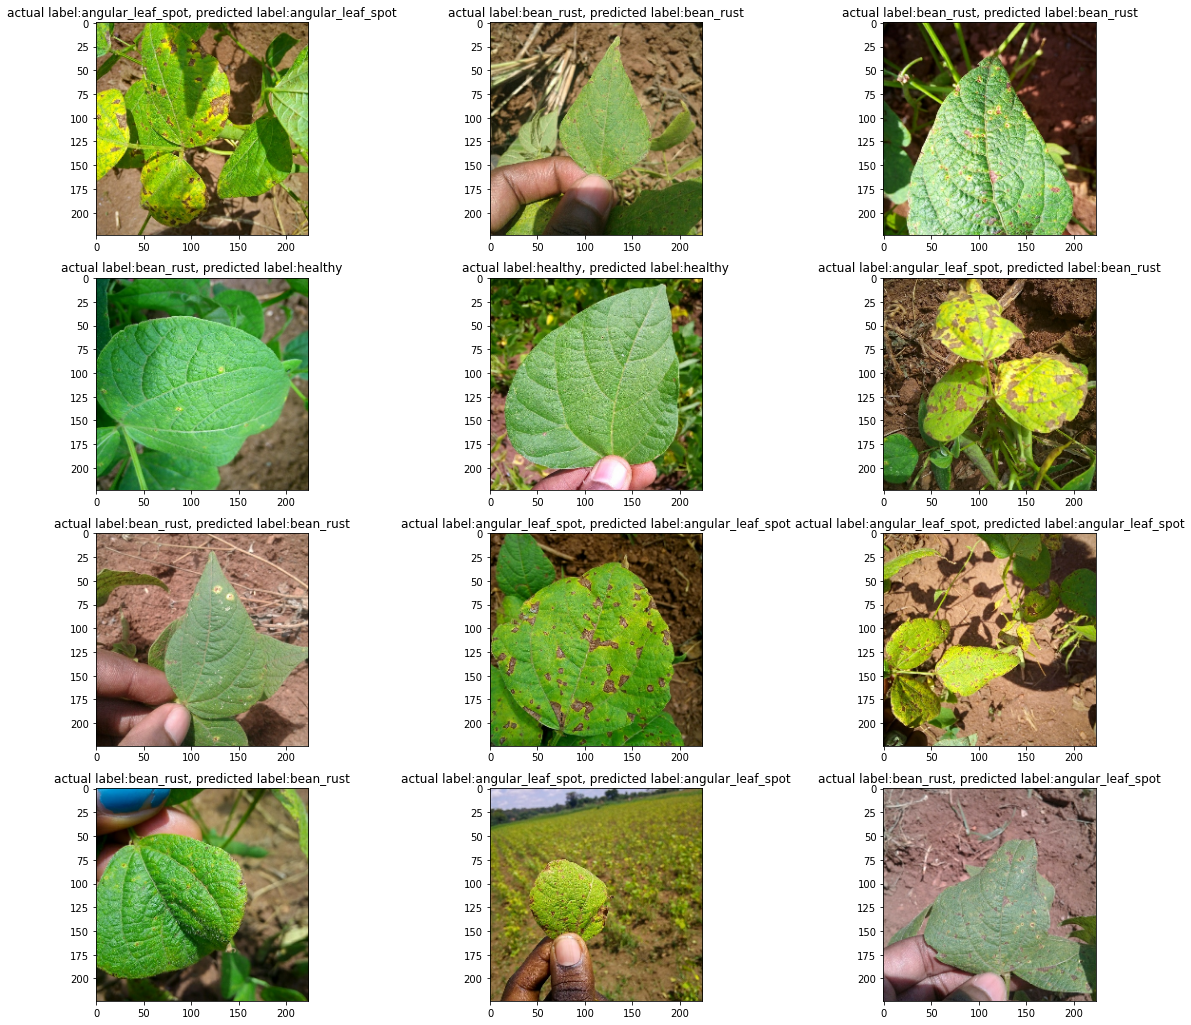

In [77]:
fig = plt.figure(figsize=(20,18))
i=1
for test_sample in dataset[1].take(12):
  img, label = test_sample[0], test_sample[1]
  img, label = scale(img, label)
  img = np.expand_dims(img, axis=0)
  # img = tf.keras.preprocessing.image.img_to_array(img)
  pred = model.predict(img)
  # print(img)
  ax = fig.add_subplot(4,3,i)
  i+=1
  ax.imshow(img[0])
  ax.set_title('actual label:' + str(info.features['label'].names[np.argmax(label)]) + ', predicted label:' + str(info.features['label'].names[np.argmax(pred)]))

In [78]:
info.features['label'].names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [113]:
for test_img, test_label in dataset[1].map(scale).batch(128):
  y_pred = model.predict(test_img)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(test_label, axis=1)
  print(tf.math.confusion_matrix(y_test, y_pred, num_classes=3))

tf.Tensor(
[[41  2  0]
 [ 9 31  3]
 [ 0  2 40]], shape=(3, 3), dtype=int32)
